## ECE495 In-class Exercise 2: Spiking Neural Networks using NengoDL

This ICE uses NengoDL and TensorFlow's Keras to:

1. Load a prebuilt dataset.
2. Build a simple *spiking* neural network that classifies images. The neural network will utilize the equivalent layers as those from ICE1! Be sure to draw the parallels between the two networks as you work through this.
3. Train the spiking neural network.
4. Evaluate the accuracy of the spiking network.

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
  
If you are using your virtual environment, the next section should run without issue. If you are not in your virtual environment (or your environment did not install properly), you'll see a lot of red.
  
Import Nengo, NengoDL, TensorFlow and other supporting libraries into your program to get started:

In [1]:
from urllib.request import urlretrieve

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

## Load and pre-process the dataset

Load and prepare the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). The pixel values of the images range from 0 through 255. Recall in ICE1, we had to normalize the values. For this spiking neural network, we do not have to do that. _Ensure you understand why we don't have to normalize the input values._

We are going to get into how data is encoded using Nengo neuron ensembles in the next few lectures. Until then, the main point you need to understand is that we cannot simply send an image into an SNN. Recall that an SNN uses spikes (only 1's) and an image is made up of pixel values ranging from 0 to 255 (integers) for MNIST. So, how might you encode pixels via spikes? 

For this network, rate encoding is used (Nengo will do this for you - don't panic). This means that if the pixel value is higher, you'll see more spikes over a duration of time. If your pixel value is 0, how many spikes do you think you'll see? Hopefully your intuition says 0 spikes! If you are curious, you can read more about this encoding in [the response](https://forum.nengo.ai/t/how-are-spikes-generated-within-nengodl/2130) to this forum question.

Why am I telling you all of this? Nengo ensembles (which will be used to rate encode your MNIST images) can only accept vector inputs (i.e. 1xN arrays). MNIST data is made up of 70,000 28x28 matrices - remember, you can click the `Variables` tab at the top to verify this info. Therefore to encode the data, we must convert all of our training and testing data to arrays. Note: this is the exact same thing the flatten layer did in our Neural Network from ICE1. As it turns out, the flatten layer does not have any trainable parameters (no weights or biases)! 

<style>
    .questioncolor {
        background-color: #906752;
    }
</style>

<div class="questioncolor">

This is the first section you are required to edit!
1. Grab the dataset from tf.keras in the exact same way you did for ICE1. Replace `???` with the correct command on the first line.
2. No need to normalize the data this time since Nengo will rate encode it for us (meaning the rate encoding would result in the same spike rates - consider why this might be). Instead, flatten each of your images by converting your matrices of training data from (60000,28,28) to (60000,784) and test data from (10000,28,28) to (10000,784). The [`reshape` command](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) will be helpful to you in flattening your images. If you'd like to avoid hardcoding values (a practice that will serve you well in the second half of this course), you might also take a look at the [`shape` command](https://numpy.org/doc/stable/reference/generated/numpy.shape.html). Replace the `???` with the correct commands. Check your Variables tab to ensure you now have the correct matrix sizes for your training and test data.

</div>

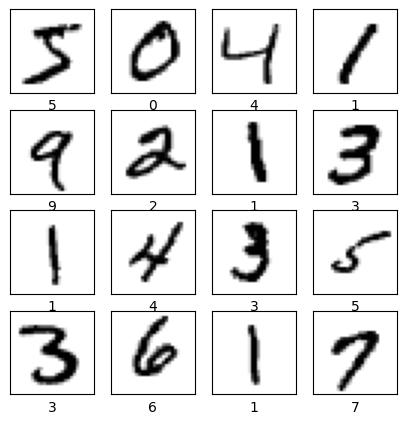

In [2]:
#Load your data
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.mnist.load_data()
)

#Take a look at your data just to be sure it loaded as expected
plt.figure(figsize=(5, 5))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

# Flatten your Images
train_images = np.reshape(train_images, (60000,784)) # this needs to get reshaped into 28 by 784
test_images = np.reshape(test_images, (10000, 784)) # manual flatten

Because this is a spiking neural network, we need to perform one more pre-processing step for our testing data: we need to incorporate time since Nengo models (and SNNs in general) always contain a temporal aspect. Think about the neurons in our brain! We don't feed our brain a photo and turn everything else off until we know what we are looking at. Our neurons are constantly taking in data and firing according to their receptive fields. Same goes for an SNN.

When training the model though, NengoDL swaps out true spiking neurons for what is called a rate-based approximation - this essentially emulates spiking neurons but avoids the additional noise and difficulty spiking neurons introduce into training. This means the training data does not need time because we are essentially training the SNN using mini-CPUs instead of true spiking neurons. This means we train our SNN without the complexity of actually training it _with spikes_.

Once trained, we officially have an SNN and will use it as such. That means when it's time to test the model (perform inference), we will be using spiking neurons; therefore, we will need to run the model for multiple timesteps in order to collect the spike data over time.

<style>
    .questioncolor {
        background-color: #906752;
    }
</style>

<div class="questioncolor">

1. For inference, as a default we will run our model for 40 time steps per image. This means we repeat the test images `n_steps` so it gives the model time to converge to a class (i.e. if we only ran it for one timestep, it'd be about 10% confidence for each of the 10 classes). Use [`np.tile`](https://numpy.org/doc/stable/reference/generated/numpy.tile.html) to repeat each image 40 times (and therefore each label 40 times) in your test data array. Your resulting matrices should have dimensions (10000,40,784) and (10000,40,1). [`np.newaxis` or `None`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) may be helpful when tiling your matrix. Replace `???` with the appropriate code.
2. You need to training data to have comparable dimensions. Add a single timestep to your training images and label matrices, resulting in dimensions (60000,1,784) and (60000,1,1), respectively. [`np.newaxis` or `None`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) will be helpful here. Replace `???` with the appropriate code.

</div>

In [3]:
# Add the temporal aspect to the test data
n_steps = 40
test_images = np.tile(test_images[:, None, :], (1,n_steps,1)) # test images repeat 40 times 
test_labels = np.tile(test_labels[:, None, None], (1,n_steps,1)) # 

# Add the single timestep to the training data to ensure dimensions match
train_images = train_images[:,None,:] # mini cpu means we only have to send it in once
train_labels = train_labels[:,None,None]

## Build a machine learning model

Before we dive in, I want to note that there are a few ways to go from a DNN to an SNN (be sure you understand the differences and pros/cons of each):
1. You can completely train a DNN in Keras, then [build a wrapper](https://www.nengo.ai/nengo-dl/examples/tensorflow-models.html) to integrate the model into NengoDL without retraining. In this case, the neurons within the Keras model are still non-spiking. This would be well-suited for a hybrid algorithm, where part is performed outside of neuromorphic computing architectures. Note: the non-spiking part of the hybrid algorithm cannot directly run on neuromorphic hardware.
2. You can completely train a DNN in Keras, then [convert it](https://www.nengo.ai/nengo-dl/examples/keras-to-snn.html) into a SNN. We covered this at a high level during Lecture 5, specifically many of the fine-tuning that must be done to get back your original DNN performance. In fact, if you visit the link, the images should look familiar. 
3. You can train an SNN directly, which is what we will do here. This method trains the network with all of the classic DNN training in mind with the ability to map directly to neuromorphic hardware, i.e. you should get decent performance right after training. You may have to fine-tune SNN parameters, but that's comparable to needing to fine-tune DNN parameters. Don't let ICE1 fool you: if you ever train a legit DNN, you'll need to fine-tune it many times to achieve state of the art results. _Yes, there is an example in the NengoDL literature regarding this method that I will not link here. If you find it, you are welcome to use it as a supplemental resource but please recognize that it will be abundantly clear if you copied it. Should you choose to go the copying route, your grade will suffer._

### Set up the layers

For this network, we will build the same model as we did in ICE1. However, you have already preprocessed your data (flattened your images) to replace the Flatten layer. That means your model will consist of the following layers, in order:
1. Dense
2. Dropout
3. Dense

Almost all deep learning methods are based on gradient descent, which means that the network being optimized needs to be differentiable. Deep neural networks are usually built using rectified linear or sigmoid neurons, as these are differentiable nonlinearities. However, in neurmorphic modelling we often want to use spiking neurons, which are not differentiable. So the challenge is how to apply deep learning methods to spiking neural networks.

A method for accomplishing this is presented in Hunsberger and Eliasmith (2016). The basic idea is to use a differentiable approximation of the spiking neurons during the training process, and the actual spiking neurons during inference. _NengoDL will perform these transformations automatically_ to develop a network to classify handwritten digits (MNIST) in a spiking network.

We will use [TensorNodes](https://www.nengo.ai/nengo-dl/tensor-node.html) to construct the same network we constructed in ICE1 within Nengo. TensorNodes allow us to directly insert TensorFlow code into Nengo - making the parallels with standard deep networks very clear (i.e. the code looks very much the same!). You will need to pay close attention to the section of the TensorNodes page regarding `nengo_dl.Layer` to construct your layers. Notice that each layer is given a name. Also notice that the given name is then passed to the next layer using a second set of parenthesis - this is how layers are connected within NengoDL. 



<style>
    .questioncolor {
        background-color: #906752;
    }
</style>

<div class="questioncolor">

Given the above information, build your model by adding the appropriate layers in place of the three `???` lines. Be sure to view the TensorNode hyperlink - it will be very helpful in calling your layers correctly. Notice that the first layer is named `inp`. Be sure to keep the output layer's name as `out` to ensure our probes used to analyze our results work correctly. Your `tf.keras.layers` should look identical to ICE1 when called within `nengo_dl.Layer`.

Below your first dense and dropout layers, you'll see an additional layer that sets these layers as LIF (`neuron_type`) layers. This ensures the network is utilizing spiking neurons. No need to touch those layers, but note the names of the layers as this will dictate in what order your layers are connected.

Also note the last two lines of this section of code. We will these two probes A LOT throughout the remainder of this ICE.

</div>

In [4]:
with nengo.Network(seed=0) as net:

    # NengoDL default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)
    nengo_dl.configure_settings(stateful=False)

    # This is the input node that will be used to rate encode in input images (i.e. our Flatten layer from ICE1)
    inp = nengo.Node(np.zeros(train_images.shape[2])) #flatten layer is the same as in ICE #1...

    # First dense layer
    a = nengo_dl.Layer(tf.keras.layers.Dense(128, activation="relu"))(inp)  #dense layer
    a = nengo_dl.Layer(neuron_type)(a)   #what's the point of this? it sets layers as neuron type to make sure its using spikes not DNNs

    # Dropout layer
    b = nengo_dl.Layer(tf.keras.layers.Dropout(.2))(a)
    b = nengo_dl.Layer(neuron_type)(b) #ensures spikes again wow!

    # Final dense layer
    out = nengo_dl.Layer(tf.keras.layers.Dense(10))(b)

    # Here we create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt") 

## Compile your model

A bit more goes into compiling your model within NengoDL due to the spiking nature of the network. 

First, NengoDL needs to set up a simulator to run the equivalent of the `model.compile`, `model.fit`, and `model.evaluate` functions we ran in ICE1 since we are not working directly within TensorFlow anymore. We still use the TensorFlow functions, but within a spiking framework in NengoDL. 

In [5]:
minibatch_size = 256
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

|                     Building network (0%)                    | ETA:  --:--:--
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00


c:\Users\C25Taylor.Harkley\anaconda3\envs\495venv\lib\site-packages\nengo_dl\simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


| #                        Optimizing graph                           | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
|  #                       Optimizing graph                           | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
| #                       Constructing graph                          | 0:00:00
|  #                      Constructing graph                          | 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
|############Constru

Before the model is ready for training, it needs a few more settings, very similar (if not identical) to those settings we utilized in ICE1. These are added during the model's compile step:

<style>
    .questioncolor {
        background-color: #906752;
    }
</style>

<div class="questioncolor">

**Optimizer** — We will use the same Adam optimization as we used in ICE1 and call it in the exact same way (reference ICE1!). Do so by filling in the `???` in the correct line.

**Metrics** - We will use the same Accuracy metric as we used in ICE1 and call it in the exact same way (reference ICE1!). Do so by filling in the `???` in the correct line.

**Loss function** — This measures how accurate the model is during training. This is where things get a little tricky! During training, we aren't using spiking neurons (remember why??). That means we can use the same TensorFlow Sparse Categorical Crossentropy as our loss function for our ICE1 network: `tf.losses.SparseCategoricalCrossentropy(from_logits=True)`. However, for testing we will be using our spiking neurons, which means we need a custom function that only evaluates the output from the network on the final timestep (as we are simulating the network over time). Both functions compute the same thing (accuracy of the predicted labels against the true labels), but they need to be connected to the appropriate probes we declared earlier (`out_p` for training, `out_p_filt` for test) and used at the appropriate times. You should use the Sparse Categorical Entropy when training and the custom `classification_accuracy` function when testing. If you switch back and forth, you'll need to recompile with the appropriate loss function and probe.

Noting the comments in the section of code where you built your model, choose the correct probe to connect to the loss function for training by replacing the `???`.

</div>

In [6]:
# Custom loss function for testing
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])

# Compile for training
sim.compile(
    optimizer="Adam",
    loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)}, #connect the training one
    metrics=["accuracy"],
)

c:\Users\C25Taylor.Harkley\anaconda3\envs\495venv\lib\site-packages\nengo_dl\simulator.py:1736: UserWarning: Number of elements (1) in ['str'] does not match number of Probes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  warnings.warn(


## Train and evaluate your model

Training the neural network model requires the following steps (same as ICE1!):

1. Feed the training data to the model. In this example, the training data is in the train_images and train_labels arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set — in this example, the test_images array.
4. Verify that the predictions match the labels from the test_labels array.

To train your network, we call the `model.fit` equivalent using our simulator. We want to use the training data and train for 5 epochs. This will complete the first two steps in training your spiking neural network.

Training your network should take about 45 seconds - 2 minutes to run. You can mess with the number of epochs or the minibatch size to speed things up. *If you do, note how this changes your results.*


<style>
    .questioncolor {
        background-color: #906752;
    }
</style>

<div class="questioncolor">

Because we train and test using different functions, we must again ensure we connect the correct probes. Connect the correct probe to the training labels by replacing the `???` with the correct probe (i.e. the output of the network). Run the training for 5 epochs by filling in the second set of `???` (this part should be identical to ICE1).

</div>

In [7]:
sim.fit(train_images, {out_p: train_labels}, epochs=5) # still training. connect training probe.

c:\Users\C25Taylor.Harkley\anaconda3\envs\495venv\lib\site-packages\nengo_dl\simulator.py:1892: UserWarning: Number of elements in input data (60000) is not evenly divisible by Simulator.minibatch_size (256); input data will be truncated.
  warnings.warn(


Epoch 1/5
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
|############Constructing graph: pre-build stage (60%)           | ETA: 0:00:00
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|############  Constructing graph: build stage (20%)             | ETA: 0:00:01
|##############Constructing graph: build stage (33%)             | ETA: 0:00:00
|##############Constructing graph: build stage (60%)             | ETA: 0:00:00
|##############Constructing graph: build stage (60%)             | ETA: 0:00:00
|##############Constructing graph: build stage (86%)####         | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|############Constructing graph: build stage (100%)###

As the model trains, the loss and accuracy metrics are displayed. This model should reach an accuracy of about 0.90 (or 90%) on the training data.

<style>
    .questioncolor {
        background-color: #906752;
    }
</style>

<div class="questioncolor">

To complete the last two steps of the training process, use the `model.evaluate` equivalent call using the simulator to check your model's performance. Now that we are using test data, we need to change our loss function to the custom function and connect the probe that evaluates our network over time (i.e. test data). Replace both `???`s with the right probe. As with our ICE1, you can choose any version of verbose to analyze results.

This will take about 30-45 seconds to run (not sure why - bonus points if you figure it out). You can check the accuracy for a fraction of the results to speed things up (recall, there are 10,000 test images) or you can check it for all of your images (choose which line to comment out). *If you do, consider whether or not this is truly representative of your results. Maybe try both ways to confirm your intuition.*

</div>

In [8]:
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy after training:",
    sim.evaluate(
        test_images[0 : 256 * 3], {out_p_filt: test_labels[0 : 256 * 3]}, verbose=0
    )["loss"],
    # sim.evaluate(test_images, {???: test_labels}, verbose=0)["loss"],
)

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|############  Constructing graph: build stage (20%)             | ETA: 0:00:00
|##############Constructing graph: build stage (33%)             | ETA: 0:00:00
|##############Constructing graph: build stage (60%)             | ETA: 0:00:00
|##############Constructing graph: build stage (86%)####         | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: bu

We can see that the spiking neural network is achieving ~90% accuracy, which is lower than what we would expect for MNIST. Some options for improving performance are increasing `n_steps`, increasing the number of training epochs, or adjusting the `minibatch_size`. The way that this network was written was to match (as closely as possible) the way we implemented ICE1. Try adjusting some of these parameters and see how it impacts your performance. _Consider the tradeoff between training time and performance when making these adjustments._



## Make Predictions

The next bit of code plots the test image being classified by your SNN and a plot that shows the change in probability for each class over `n_steps`. The legend in the right plot corresponds to the 10 possible labels. The color with the highest probability on the last time step is classified as the image's class by the SNN. 

A few conceptual things to consider (_hint hint_): 
1. Notice that the probability starts at 0.10 for all classes.Does this make sense?
2. Do any of the digits get misclassified or were they close to another digit's probability? Based on looking at the handwritten digit(s) in question, why might this have been the case?
3. Would more timesteps have helped with any misclassifications? Why or why not?
4. Why do you think the SNN (without any modifications to ICE2 parameters) didn't perform as well as the DNN from ICE1?

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
|############Constructing graph: pre-build stage (60%)           | ETA: 0:00:00
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|##############Constructing graph: build stage (26%)             | ETA: 0:00:00
|##############Constructing graph: build stage (33%)             | ETA: 0:00:00
|##############Constructing graph: build stage (60%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
1/1 [=======

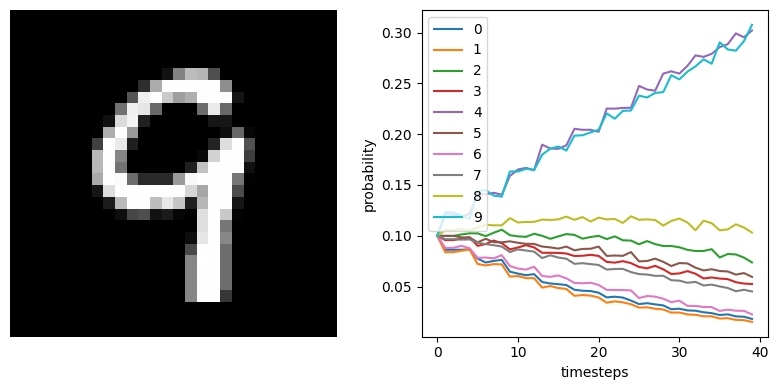

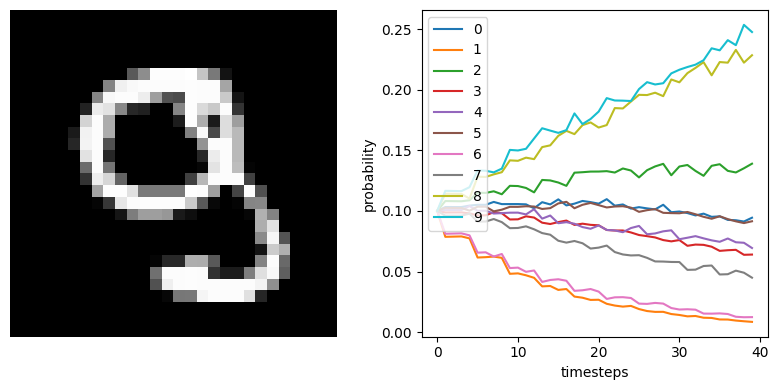

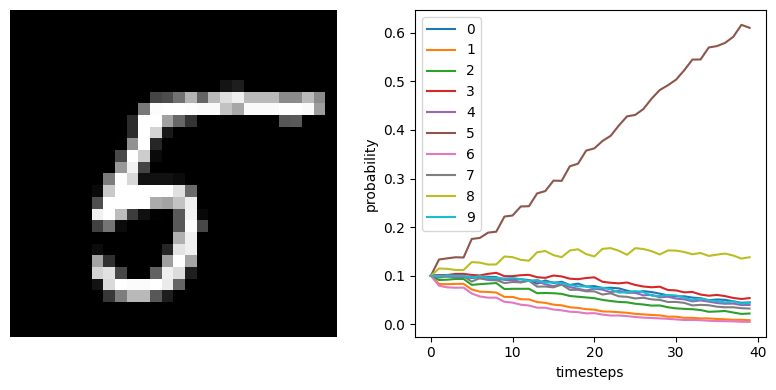

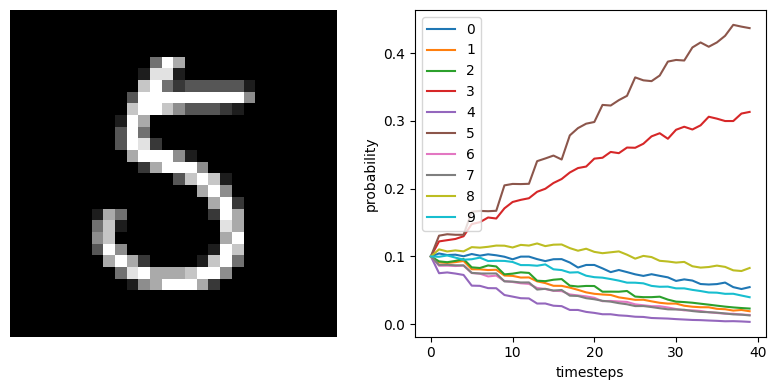

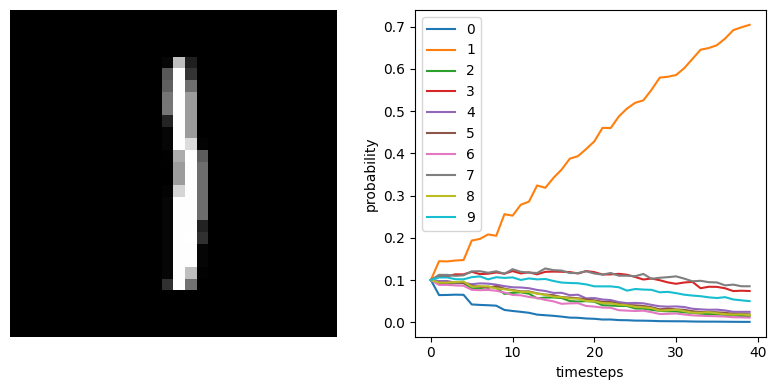

In [9]:
data = sim.predict(test_images[:256])

for i in range(5): 
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[150 + i, 0].reshape((28, 28)), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.plot(tf.nn.softmax(data[out_p_filt][150 + i]))
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")
    plt.ylabel("probability")
    plt.tight_layout() # testing loss function grabs data at the last timestep...